## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import plotly.express as px
%matplotlib inline


In [3]:
df = pd.read_csv('./ab_test_ensembles.csv')
df.head() 

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [5]:
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [6]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [6]:
pd.crosstab(df['user_type'], df['variants'])

variants,standard,svm_ensemble_v_1_22
user_type,,
new_user,73797,73441
registered_user,73442,73798


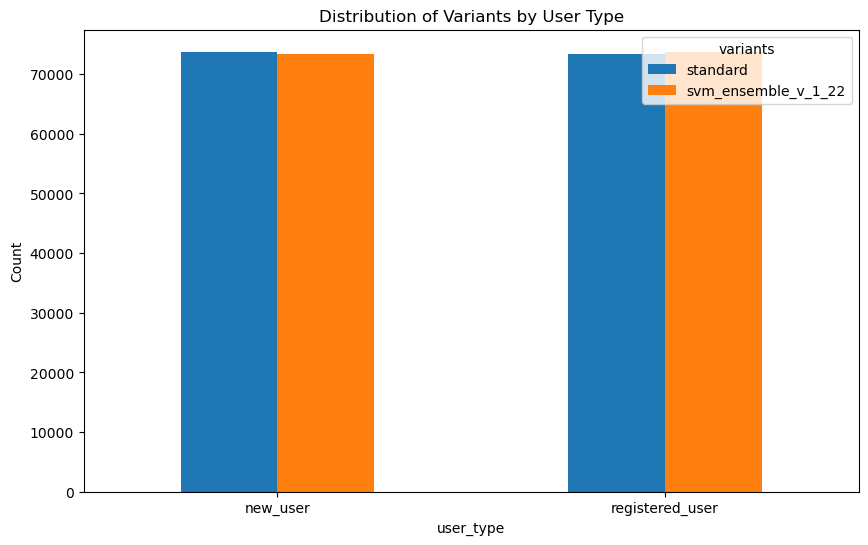

In [23]:
ct = pd.crosstab(df['user_type'], df['variants'])
ct.plot(kind='bar', figsize=(10, 6), rot = 0)
plt.title('Distribution of Variants by User Type')
plt.ylabel('Count')
plt.show()

In [7]:
df.group.value_counts(normalize=True)

group
treatment    0.500126
control      0.499874
Name: proportion, dtype: float64

In [7]:
conversion_rates = df.groupby('group')['converted']
std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)
conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

C:\Users\user\AppData\Local\Temp\ipykernel_4716\609047879.py:4: FutureWarning: The provided callable <function mean at 0x000001DE7F131260> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})


,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118920,0.323694,0.000843


In [8]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


In [10]:
df.user_type.value_counts(normalize=True)

user_type
registered_user    0.500003
new_user           0.499997
Name: proportion, dtype: float64

In [9]:
conversion_rates = df.groupby('user_type')['converted']
std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)
conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

C:\Users\user\AppData\Local\Temp\ipykernel_4716\3031926789.py:4: FutureWarning: The provided callable <function mean at 0x000001DE7F131260> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})


,CR mean,CR std,CR se
user_type,,,
new_user,0.119154,0.323970,0.000844
registered_user,0.120164,0.325154,0.000847


In [10]:
new_user = df[df['user_type'] == 'new_user']
new_user.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user
11,1cc7ebbb-efb9-43a6-9230-11161ae910ba,2022-05-21 22:37:47.774891,treatment,svm_ensemble_v_1_22,0,United Kingdom,58+,new_user
14,137d7bf0-309c-4aad-ad9e-302a2f45dc70,2022-05-22 11:45:11.327945,treatment,svm_ensemble_v_1_22,0,United Kingdom,50-57,new_user


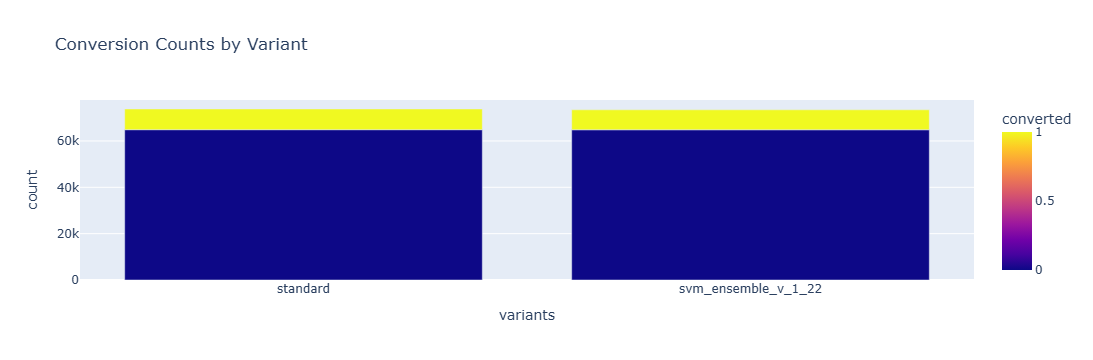

In [12]:
plot_df = new_user.groupby('variants')['converted'].value_counts().reset_index(name='count')
fig = px.bar(plot_df, 
             x='variants', 
             y='count', 
             color='converted', 
             barmode='group',
             title='Conversion Counts by Variant')
fig.show()

In [13]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = new_user[new_user['group'] == 'control']['converted']
treatment_results = new_user[new_user['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.89
p-value: 0.059
CI 95% for control group: [0.118, 0.123]
CI 95% for treatment group: [0.115, 0.120]


In [14]:
old_user = df[df['user_type'] == 'registered_user']
old_user.groupby('variants')['converted'].value_counts()

variants             converted
standard             0            64638
                     1             8804
svm_ensemble_v_1_22  0            64909
                     1             8889
Name: count, dtype: int64

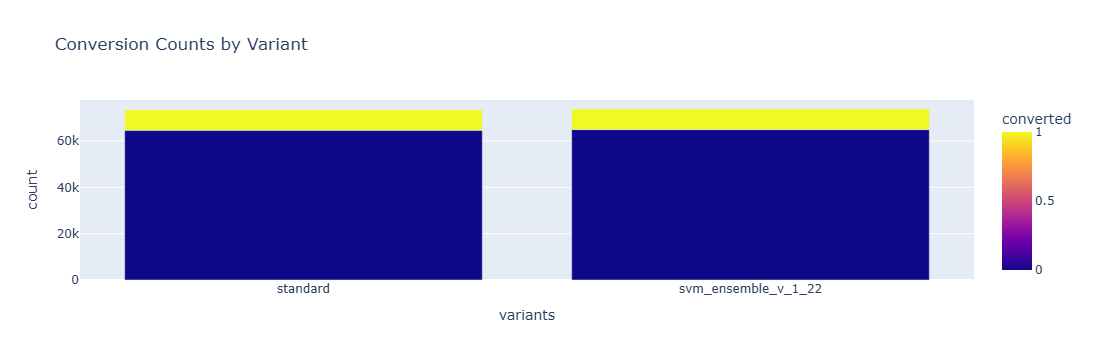

In [16]:
plot_df = old_user.groupby('variants')['converted'].value_counts().reset_index(name='count')
fig = px.bar(plot_df, 
             x='variants', 
             y='count', 
             color='converted', 
             barmode='group',
             title='Conversion Counts by Variant')
fig.show()

In [18]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = old_user[old_user['group'] == 'control']['converted']
treatment_results = old_user[old_user['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)
print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: -0.13
p-value: 0.894
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]


***Вывод***: наше p-значение = 0.216 для всей выборки является высоким показателем и согласно статистическому выводу, мы не можем отклонить нулевую гипотезу Н0,  что означает наш сайт никак статистически значимо не влияет на уровень конверсии.
Доверительный интервал для испытуемой группы [0.119, 0.122] или примерно 12% и не достигает цели 15%.
Даже разделение выборки на новых и зарегистрированных пользователей не позволило достичь значения 15%.
Наиболее вероятно реальный уровень конверсии сайта с новым дизайном не принесет желаемого результата увеличения конверсии.
